In [ ]:
!pip install seaborn

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.integrate import simps
from numpy import trapz
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("Score")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
def local_max(data):
  peaks, _ = find_peaks(data['Amplitude'], height=0)
  df_copy = data.copy()
  df_copy = df_copy.drop(columns=['Amplitude'])
  loc_max = data['Amplitude'][peaks]
  return df_copy.join(loc_max, how='right')

In [ ]:
def plot_loc_max(data):
  loc_max = local_max(data)
  plt.plot(data['Wave_Lenght'], data['Amplitude'])
  plt.plot(loc_max['Wave_Lenght'], loc_max['Amplitude'], "x")
  plt.show()

In [ ]:
def filter_by_max_glob(data, x=0.05):
  loc_max = local_max(data)
  global_max = loc_max['Amplitude'].max()
  treshold = x * global_max
  return data[data['Amplitude'] >= treshold].reset_index()

In [ ]:
def distance_loc_max(data):
  return data['Wave_Lenght'].diff()

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  heatmap = sns.heatmap(cm, annot=True, fmt='d')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.figure()
  plt.show()

In [ ]:
def plot_ROC(y_true, y_pred):
  fpr, tpr, threshold = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  
  fig, ax = plt.subplots()

  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)

  ax.plot(fpr, tpr, color='b',
          label=r'ROC (AUC = %0.2f)' % (roc_auc),
          lw=2, alpha=.8)

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="Receiver operating characteristic")
  ax.legend(loc="lower right")

  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

In [ ]:
def plot_precision_recall(y_true, y_pred):
  precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
  p_r_auc = auc(recall, precision)

  plt.plot(recall, precision, label = 'AUC = %0.2f' % p_r_auc)
  plt.legend(loc = 'lower right')
  plt.plot([1, 0], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.xlabel('Recall')
  plt.ylabel('Precision')

  plt.show()

In [ ]:
def make_prediction(x, y, model):
  X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 16)

  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)

  print(classification_report(y_val, y_pred))

  fpr, tpr, threshold = roc_curve(y_val, y_pred)
  roc_auc = auc(fpr, tpr)

  plot_confusion_matrix(y_val, y_pred) 

  fig, ax = plt.subplots()

  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)

  ax.plot(fpr, tpr, color='b',
          label=r'ROC (AUC = %0.2f)' % (roc_auc),
          lw=2, alpha=.8)

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="Receiver operating characteristic")
  ax.legend(loc="lower right")

  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

In [ ]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
def plot_cv_indices(cv, X, y, ax, n_splits, lw=20):

    """Create a sample plot for indices of a cross-validation object."""
    
    # Generate the training/testing visualizations for each CV split
    for ii, (train, val) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[train] = 0
        indices[val] = 1

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y.to_numpy(), marker='_', lw=lw, cmap=cmap_data)
    # Formatting
    yticklabels = list(range(n_splits)) + ['class']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+1.2, -.2])
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02)), Patch(color=cmap_data(0)), Patch(color=cmap_data(1.0))],
              ['Validation set', 'Training set', 'Healthy', 'Sick'], loc=(1.02, .4))
   
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [ ]:
def make_predictions(X, y, model, n_splits):
  cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  for i, (train, val) in enumerate(cv.split(X, y)):
      print(len(X.iloc[train]))
      print(len(X.iloc[val]))
      model.fit(X.iloc[train], y.iloc[train])
      y_pred = model.predict(X.iloc[val])

      print(classification_report(y.iloc[val], y_pred))

      fpr, tpr, threshold = roc_curve(y.iloc[val], y_pred)
      roc_auc = auc(fpr, tpr)

      interp_tpr = np.interp(mean_fpr, fpr, tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(roc_auc)
      plot_confusion_matrix(y.iloc[val], y_pred)

  fig, ax = plt.subplots()

  fig1, ax1 = plt.subplots()
  plot_cv_indices(cv, X, y, ax1, n_splits)

  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="Receiver operating characteristic", xlabel='False Positive Rate', ylabel='True Positive Rate')
  ax.legend(loc="lower right")

  plt.show()

In [ ]:
def calculate_dissimilarity(sym, exp, f):
  #to see what % of the interferograms overlap
  #for simulated signal
  area_sym = simps(sym, dx=1)
  #for experimental signal
  area_exp = simps(exp, dx=1)
  return abs(1 - np.round(((area_exp * f)/area_sym),4))

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [ ]:
def extract_features_vector(data, signal_0, niche_lenght, is_sick, filter_threshold):
  y = 1+np.cos((2*np.pi*1.0003*niche_lenght)/(signal_0['Wave_Lenght']))
  sym_sig = y*signal_0['Amplitude']
  plt.plot(signal_0['Wave_Lenght'], y*signal_0['Amplitude'])
  data = filter_by_max_glob(data, filter_threshold)
  loc_max = local_max(data)
  global_max = loc_max['Amplitude'].max()
  local_max_count = len(loc_max)
  min_wave = data['Wave_Lenght'].min()
  max_wave = data['Wave_Lenght'].max()
  amplitude = global_max - data['Amplitude'].min()
  local_max_distance = distance_loc_max(loc_max)
  local_max_distance_avg = local_max_distance.mean()
  local_max_distance_max = local_max_distance.max()
  local_max_distance_min = local_max_distance.min()
  local_max_distance_median = local_max_distance.median()
  factor = sym_sig.max() / global_max
  dissimilarity = calculate_dissimilarity(sym_sig, data['Amplitude'], factor)
  rmse1 = rmse(data['Amplitude']*factor, sym_sig)
  lambda0 = data[data['Amplitude'] == global_max][['Wave_Lenght']].values[0]
  lambda0_sym = signal_0[signal_0['Amplitude'] == signal_0['Amplitude'].max()][['Wave_Lenght']].values[0]
  wave_diff = lambda0_sym - lambda0
  data['Wave_Diff'] = data['Wave_Lenght'] + wave_diff
  plt.plot(data['Wave_Diff'], data['Amplitude']*factor, c='r')
  features = np.array([global_max, local_max_count, min_wave, max_wave, amplitude, local_max_distance_avg, local_max_distance_max, local_max_distance_min, local_max_distance_median, rmse1, factor, lambda0[0], lambda0_sym[0], dissimilarity, wave_diff[0], niche_lenght, filter_threshold, is_sick])
  return pd.DataFrame(features.reshape(1,18), columns=['global_max', 'local_max_count', 'min_wave', 'max_wave', 'amplitude', 'local_max_distance_avg', 'local_max_distance_max', 'local_max_distance_min', 'local_max_distance_median', 'rmse', 'factor', 'lambda0', 'lambda0_sym', 'dissimilarity', 'wave_diff', 'niche_lenght', 'filter_threshold', 'is_sick'])


In [ ]:
import os
df_exp = pd.DataFrame()
#path to data
dir_path = '1550-srebro/'
df_0 = pd.read_csv('0.CSV', sep=',', header=None, names=['Wave_Lenght', 'Amplitude'])

for dir in os.listdir(dir_path):
  for filename in os.listdir(dir_path + dir):
    if filename != 'REF.CSV': 
      df = pd.read_csv(dir_path + dir + '/' + filename, sep=',', header=None, names=['Wave_Lenght', 'Amplitude'], skiprows=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
      target = 0 if float(dir) < 1.39 else 1
      features = extract_features_vector(df, df_0, 280000, target, 0.05)
      df_exp = df_exp.append(features)
df_exp = df_exp.reset_index(drop=True)
df_exp.to_csv('df_cancer.csv', index=False)

In [ ]:
df_cancer = pd.read_csv('df_cancer.csv')
df_cancer = df_cancer.sort_values(['is_sick'])
y_cancer = df_cancer[['is_sick']]
X_cancer = df_cancer.drop(columns=['is_sick'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


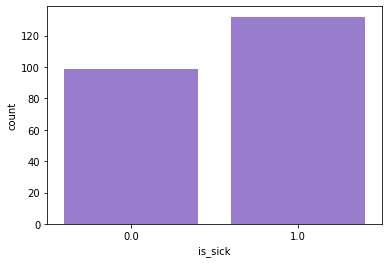

In [ ]:
sns.countplot(df_cancer['is_sick'], color='mediumpurple')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_cancer, y_cancer, test_size = 0.2, random_state = 16)

In [ ]:
%%time
from xgboost import XGBClassifier
model_xgb = XGBClassifier()
# model_xgb.fit(X_train, y_train)

CPU times: user 12.1 ms, sys: 6.03 ms, total: 18.1 ms
Wall time: 115 ms


154
77
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        33
         1.0       1.00      1.00      1.00        44

    accuracy                           1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


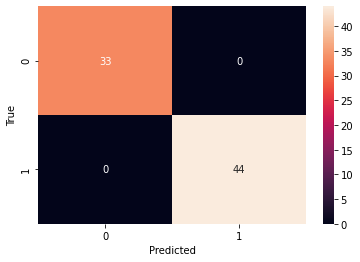

<Figure size 432x288 with 0 Axes>

154
77
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        33
         1.0       1.00      1.00      1.00        44

    accuracy                           1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77



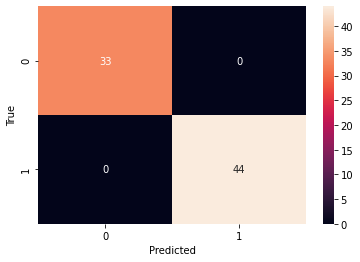

<Figure size 432x288 with 0 Axes>

154
77
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        33
         1.0       1.00      1.00      1.00        44

    accuracy                           1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77



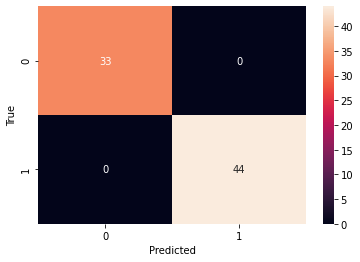

<Figure size 432x288 with 0 Axes>

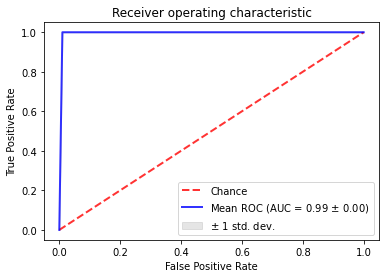

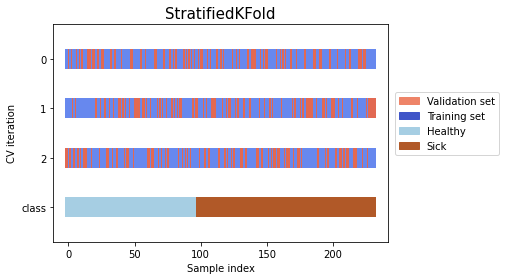

CPU times: user 1.42 s, sys: 420 ms, total: 1.84 s
Wall time: 1.58 s


In [ ]:
%%time
make_predictions(X_cancer, y_cancer, model_xgb, 3)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


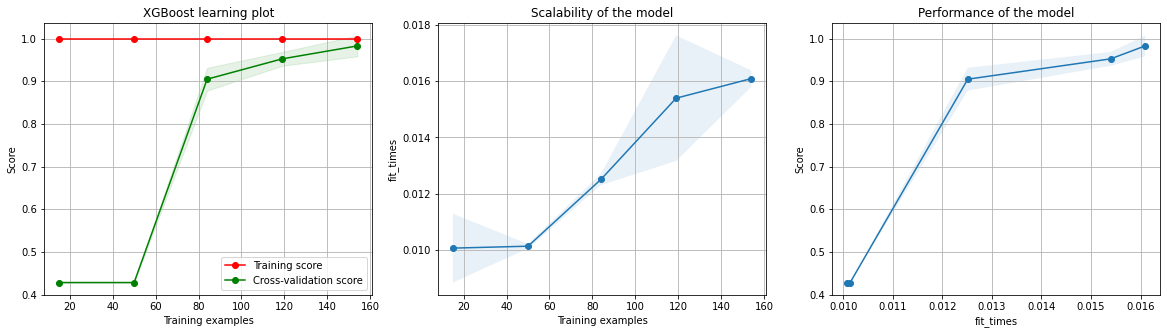

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
plot_learning_curve(model_xgb, "XGBoost learning plot", X_cancer, y_cancer, cv=cv)
plt.show()

In [ ]:
%%time
from sklearn.naive_bayes import GaussianNB
model_nb = GaussianNB()
# model_nb.fit(X_train, y_train)

CPU times: user 2.44 ms, sys: 0 ns, total: 2.44 ms
Wall time: 4.51 ms


In [ ]:
# %%time
# y_pred = model_nb.predict(X_val)

154
77
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94        33
         1.0       0.98      0.93      0.95        44

    accuracy                           0.95        77
   macro avg       0.95      0.95      0.95        77
weighted avg       0.95      0.95      0.95        77



/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


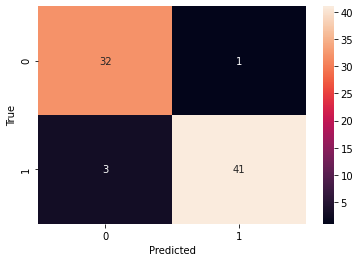

<Figure size 432x288 with 0 Axes>

154
77
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        33
         1.0       1.00      0.91      0.95        44

    accuracy                           0.95        77
   macro avg       0.95      0.95      0.95        77
weighted avg       0.95      0.95      0.95        77



/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


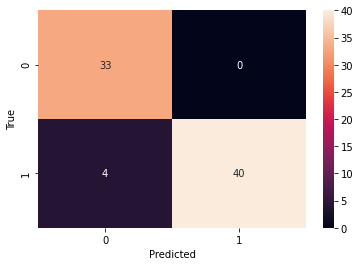

<Figure size 432x288 with 0 Axes>

154
77
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        33
         1.0       1.00      0.98      0.99        44

    accuracy                           0.99        77
   macro avg       0.99      0.99      0.99        77
weighted avg       0.99      0.99      0.99        77



/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


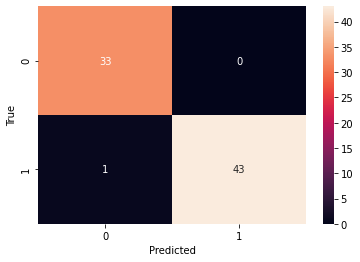

<Figure size 432x288 with 0 Axes>

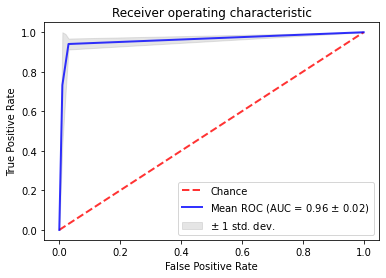

CPU times: user 1.23 s, sys: 365 ms, total: 1.6 s
Wall time: 1.27 s


In [ ]:
%%time
make_predictions(X_cancer, y_cancer, model_nb, 3)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

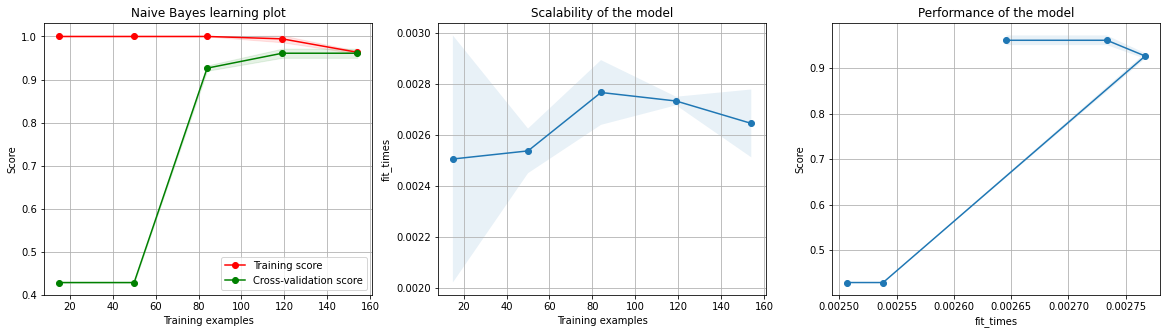

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
plot_learning_curve(model_nb, "Naive Bayes learning plot", X_cancer, y_cancer, cv=cv)
plt.show()

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
# model_rf.fit(X_train, y_train)

CPU times: user 305 ms, sys: 12.8 ms, total: 318 ms
Wall time: 449 ms


In [ ]:
# %%time
# y_pred = model_rf.predict(X_val)

154
77
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        33
         1.0       1.00      1.00      1.00        44

    accuracy                           1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


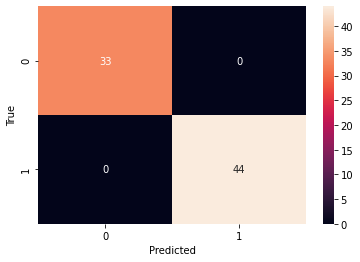

<Figure size 432x288 with 0 Axes>

154
77
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        33
         1.0       1.00      1.00      1.00        44

    accuracy                           1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


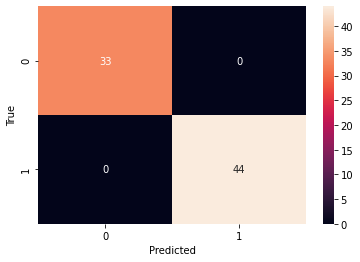

<Figure size 432x288 with 0 Axes>

154
77
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        33
         1.0       1.00      0.98      0.99        44

    accuracy                           0.99        77
   macro avg       0.99      0.99      0.99        77
weighted avg       0.99      0.99      0.99        77



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


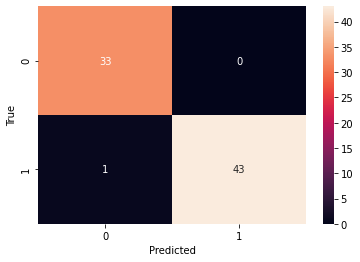

<Figure size 432x288 with 0 Axes>

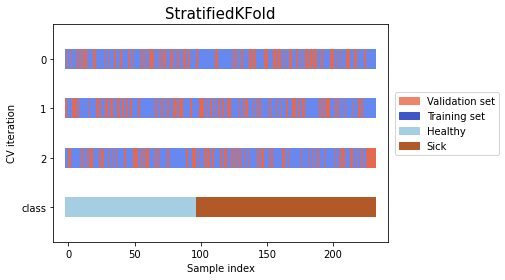

CPU times: user 1.72 s, sys: 374 ms, total: 2.09 s
Wall time: 1.76 s


In [ ]:
%%time
make_predictions(X_cancer, y_cancer, model_rf, 3)

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
plot_learning_curve(model_rf, "Random Forest learning plot", X_cancer, y_cancer, cv=cv)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 